In [131]:
import numpyro
import numpyro.distributions as dist
import jax.random as random
import einops
import jax
import jax.numpy as jnp


def get_example_image(image_shape, sv_r, indexes_of_high, mean_0,var_0,mean_1,var_1,rng_key):
    """
    we will create a simulation of the image with supervoxel segmentation each super voxel 
    at first extremely simplified case with square supervoxels each filled with predefined gausiians output
    we will generate couple of such and try to make a graph model that would recognize the diffrences
    indexes_of_high - will be a set of tuples indicating w and  h coordinates
    """ 
    #1)create empy image
    image= jnp.zeros(image_shape)
    #2) reshape to get as las two dims sv size
    image= einops.rearrange(image, '(w sw) (h sh) ->w h sw sh', sw=sv_r,sh=sv_r )
    image=numpyro.sample('mu', dist.Normal(mean_0,var_0), sample_shape=image.shape,rng_key=rng_key)
    #populate the sv areas with goussian noise of mean and var 1 if index is in indexes_of_high and mean and var 0 otherwise
    rng_key_new, old= random.split(rng_key)
    for coord in indexes_of_high:
        rng_key_new, old= random.split(rng_key_new)
        x,y=coord
        image.at[x,y,:,:].set(numpyro.sample('mu_1', dist.Normal(mean_1,var_1), sample_shape=(sv_r,sv_r),rng_key=rng_key_new))

    #reshape back to original image shape
    image= einops.rearrange(image, 'w h sw sh -> (w sw) (h sh) ', sw=sv_r,sh=sv_r )
    return image

rng_key = random.PRNGKey(3)
rng_key_new,old = random.split(rng_key)

mean_0 =1
var_0=1
mean_1=2
var_1=0.5
image_shape=(64,64)
sv_r=8
indexes_of_high=[(0,0), (1,1), (2,2)]
get_example_image(image_shape, sv_r, indexes_of_high, mean_0,var_0,mean_1,var_1,old)
v_get_example_image=jax.vmap(get_example_image,in_axes=(None,None,None,None,None,None,None,0))

#                             ,in_axes=(0, 0,0)

In [132]:
def build_example_dataset():
    """ 
    using get_example_image  we will create multiple instances of diffrent images - we will save images
    task here will be graph level predictions 
    """
    num_per_class=50
    mean_0 =1
    var_0=1
    mean_1=2
    var_1=0.5
    image_shape=(64,64)
    sv_r=8
    a=v_get_example_image(image_shape, sv_r, [(0,0), (1,1), (2,2), (3,3)], mean_0,var_0,mean_1,var_1,random.split(rng_key_new,num_per_class  ))
    b=v_get_example_image(image_shape, sv_r, [(0,0), (0,1), (0,2), (0,3)], mean_0,var_0,mean_1,var_1,random.split(rng_key_new,num_per_class  ))
    c=v_get_example_image(image_shape, sv_r, [(0,0), (1,1), (0,1), (1,1)], mean_0,var_0,mean_1,var_1,random.split(rng_key_new,num_per_class  ))
    images=jnp.concatenate([a,b,c],axis=0)
    labels_a= jnp.ones(num_per_class)
    labels_b= jnp.ones(num_per_class)*2
    labels_c= jnp.ones(num_per_class)*3
    labels= jnp.concatenate([labels_a,labels_b, labels_c])
    return images,labels

dummy_dataset=build_example_dataset()
dummy_dataset[0].shape

(150, 64, 64)

In [133]:
# def get_graph_from_image_differentaible():
#     """ 
#     we will create a graph from a given image a procedure need to be differentiable
#     """
#     # first we need to encode the svs into tokens - we will flatten and apply dense
    
#     #  now a bit harder we need to get the edges for now we will just connect with previous/next in each axis
#     node_features = jnp.array([[0.], [2.], [4.], [6.]])
#       senders = jnp.array([0, 1, 2, 3, 0])
#   receivers = jnp.array([1, 2, 0, 0, 3])

In [134]:
# import jraph
# import jax.numpy as jnp

# # Define a three node graph, each node has an integer as its feature.
# node_features = jnp.array([[0.], [1.], [2.]])

# # We will construct a graph for which there is a directed edge between each node
# # and its successor. We define this with `senders` (source nodes) and `receivers`
# # (destination nodes).
# senders = jnp.array([0, 1, 2])
# receivers = jnp.array([1, 2, 0])

# # You can optionally add edge attributes.
# edges = jnp.array([[5.], [6.], [7.]])

# # We then save the number of nodes and the number of edges.
# # This information is used to make running GNNs over multiple graphs
# # in a GraphsTuple possible.
# n_node = jnp.array([3])
# n_edge = jnp.array([3])

# # Optionally you can add `global` information, such as a graph label.

# global_context = jnp.array([[1]])
# graph = jraph.GraphsTuple(nodes=node_features, senders=senders, receivers=receivers,
# edges=edges, n_node=n_node, n_edge=n_edge, globals=global_context)

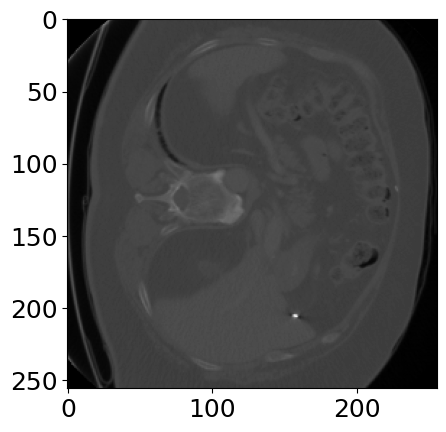

(256, 256, 4)

In [135]:
import h5py
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from skimage import data

matplotlib.rcParams['font.size'] = 18
f = h5py.File('/workspaces/jax_cpu_experiments_b/hdf5_loc/example_mask.hdf5', 'r+')
label=f["label"][:,:]
image=f["image"][:,:]
masks=f["masks"][:,:,:]
plt.imshow(image, cmap=plt.cm.gray)
plt.show()
masks.shape

In [136]:
indicies =jnp.arange(81).reshape(9,9)
shift_x=1
shift_y=1
indicies_a=indicies[0::2,0::2]
indicies_b=indicies[1::2,0::2]
indicies_c=indicies[0::2,1::2]
indicies_d=indicies[1::2,1::2]
print(f"indicies_a {indicies_a.shape} indicies_b {indicies_b.shape} indicies_c {indicies_c.shape} indicies_d {indicies_d.shape} ")


indicies_a (5, 5) indicies_b (4, 5) indicies_c (5, 4) indicies_d (4, 4) 


In [137]:
indicies

Array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
       [ 9, 10, 11, 12, 13, 14, 15, 16, 17],
       [18, 19, 20, 21, 22, 23, 24, 25, 26],
       [27, 28, 29, 30, 31, 32, 33, 34, 35],
       [36, 37, 38, 39, 40, 41, 42, 43, 44],
       [45, 46, 47, 48, 49, 50, 51, 52, 53],
       [54, 55, 56, 57, 58, 59, 60, 61, 62],
       [63, 64, 65, 66, 67, 68, 69, 70, 71],
       [72, 73, 74, 75, 76, 77, 78, 79, 80]], dtype=int32)

In [138]:


curr_x=2
curr_y=2

curr_analyzed= indicies_a
x_op=indicies_c
y_op=indicies_b

print(f"curr {curr_analyzed[curr_x,curr_y]}  left {y_op[curr_x,curr_y-1]} right {y_op[curr_x,curr_y]}  bottom {x_op[curr_x,curr_y]} top {x_op[curr_x-1,curr_y]} ")


curr 40  left 47 right 49  bottom 41 top 23 


In [139]:
def get_neighbour_indicies(curr_x,curr_y,curr_analyzed,x_op,y_op,x_subtr,y_subtr,x_add,y_add):
    left=y_op[curr_x,curr_y-y_subtr]
    right=y_op[curr_x,curr_y+y_add]
    bottom=x_op[curr_x+x_add,curr_y]
    top=x_op[curr_x-x_subtr,curr_y]
    return (left,right,bottom,top)

def get_neighbours_a(curr_x,curr_y,indicies_a,indicies_b,indicies_c,indicies_d):
    x_subtr=1
    y_subtr=1
    x_add=0
    y_add=0
    curr_analyzed=indicies_a
    x_op=indicies_b
    y_op=indicies_c
    print(f"currr {curr_analyzed[curr_x,curr_y]}")
    return get_neighbour_indicies(curr_x,curr_y,curr_analyzed,x_op,y_op,x_subtr,y_subtr,x_add,y_add)


def get_neighbours_b(curr_x,curr_y,indicies_a,indicies_b,indicies_c,indicies_d):
    x_subtr=0
    y_subtr=1
    x_add=1
    y_add=0
    curr_analyzed=indicies_b
    x_op=indicies_a
    y_op=indicies_d
    print(f"currr {curr_analyzed[curr_x,curr_y]}")
    return get_neighbour_indicies(curr_x,curr_y,curr_analyzed,x_op,y_op,x_subtr,y_subtr,x_add,y_add)

def get_neighbours_c(curr_x,curr_y,indicies_a,indicies_b,indicies_c,indicies_d):
    x_subtr=1
    y_subtr=0
    x_add=0
    y_add=1
    curr_analyzed=indicies_c
    x_op=indicies_d
    y_op=indicies_a
    print(f"currr {curr_analyzed[curr_x,curr_y]}")
    return get_neighbour_indicies(curr_x,curr_y,curr_analyzed,x_op,y_op,x_subtr,y_subtr,x_add,y_add)

def get_neighbours_d(curr_x,curr_y,indicies_a,indicies_b,indicies_c,indicies_d):
    x_subtr=0
    y_subtr=0
    x_add=1
    y_add=1
    curr_analyzed=indicies_d
    x_op=indicies_c
    y_op=indicies_b
    print(f"currr {curr_analyzed[curr_x,curr_y]}")
    return get_neighbour_indicies(curr_x,curr_y,curr_analyzed,x_op,y_op,x_subtr,y_subtr,x_add,y_add)



In [140]:
indicies

Array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
       [ 9, 10, 11, 12, 13, 14, 15, 16, 17],
       [18, 19, 20, 21, 22, 23, 24, 25, 26],
       [27, 28, 29, 30, 31, 32, 33, 34, 35],
       [36, 37, 38, 39, 40, 41, 42, 43, 44],
       [45, 46, 47, 48, 49, 50, 51, 52, 53],
       [54, 55, 56, 57, 58, 59, 60, 61, 62],
       [63, 64, 65, 66, 67, 68, 69, 70, 71],
       [72, 73, 74, 75, 76, 77, 78, 79, 80]], dtype=int32)

In [141]:
get_neighbours_c(curr_x,curr_y,indicies_a,indicies_b,indicies_c,indicies_d)

currr 41


(Array(40, dtype=int32),
 Array(42, dtype=int32),
 Array(50, dtype=int32),
 Array(32, dtype=int32))

In [142]:
curr_x=2
curr_y=2

curr_analyzed= indicies_d
x_op=indicies_b
y_op=indicies_c

print(f"curr {curr_analyzed[curr_x,curr_y]}  left {y_op[curr_x,curr_y]} right {y_op[curr_x,curr_y+1]}  bottom {x_op[curr_x+1,curr_y]} top {x_op[curr_x,curr_y]} ")


curr 50  left 41 right 43  bottom 67 top 49 


In [143]:
""" 
so we need for each initial masks get mask of the same x and y shape but set it as
aranged so we will get mask unique indicies
then to each mask we will add sums to get completely unique indicies 
so to indicies a 0 to b x*y (shape) to c x*y*2 and to d x*y*3
this should give us the correct indicies that will be valid after flattening the tokens
now we have neighbour svs of each entry of the each mask in some other mask by construction
in order to deal easier with corner cases we can pad the arranged array with lets say -1 and then filter out sch cases
important consideration also is that initial grid will be divided into masks and it cen get uneven shapes - we need to adress it 
"""

' \nso we need for each initial masks get mask of the same x and y shape but set it as\naranged so we will get mask unique indicies\nthen to each mask we will add sums to get completely unique indicies \nso to indicies a 0 to b x*y (shape) to c x*y*2 and to d x*y*3\nthis should give us the correct indicies that will be valid after flattening the tokens\nnow we have neighbour svs of each entry of the each mask in some other mask by construction\nin order to deal easier with corner cases we can pad the arranged array with lets say -1 and then filter out sch cases\nimportant consideration also is that initial grid will be divided into masks and it cen get uneven shapes - we need to adress it \n'